### Домашня работа 2.
### Логистическая регрессия. Работа с признаками


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Неэффективная реализация кода может негативно отразиться на оценке.

In [1]:
print('Всем удачи!👒 Тут она точно пригодится.')

Всем удачи!👒 Тут она точно пригодится.


In [2]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Логистическая регрессия своими руками (4 балла)

Реализуйте логистическую регрессию, обучаемую с помощью:

**Задание 1 (1.5 балла). Градиентного спуска**

**Задание 2 (1.5 балла). Стохастического градиентного спуска**

Во всех пунктах необходимо соблюдать следующие условия:
- Градиентный спуск необходимо записать в векторном виде
- Циклы средствами python допускается использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

        проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) задаваемого параметром `tolerance`;


        достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса loss_history. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);

Инициализировать веса можно случайным образом или нулевым вектором.

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$

In [3]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-6, max_iter=5000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration

    def expand(self, X):
        # Добавляем свободный признак
        X_reshaped = np.column_stack((X, np.ones((X.shape[0], 1))))

        return X_reshaped


    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []

        self.w = self.w0

        batch_size = 20

        X = self.expand(X)

        for i in range(self.max_iter):
          # запоминаем предыдущее значение фич
          prev = self.w

          if self.gd_type == 'stochastic':
            # берем рандомные индексы
            batch_ids = np.random.randint(X.shape[0], size = batch_size)
            # делим на батчи дату
            X_batch = X[batch_ids, :]
            # делим на батчи таргет
            y_batch = y[batch_ids]
            # стохастический градиентный спуск
            self.w = self.w - self.eta / X_batch.shape[0] * self.calc_gradient(X_batch, y_batch)

            self.loss_history.append(self.calc_loss(X, y))
            # смотрим на разницу весов на итерациях и если меньше толеранц, выходим
            if np.linalg.norm(self.w - prev) < self.tolerance:

                break

          elif self.gd_type == 'full':
            # полный градиентный спуск
            self.w = self.w - self.eta / X.shape[0] * self.calc_gradient(X, y)

            self.loss_history.append(self.calc_loss(X, y))

            if np.linalg.norm(self.w - prev) < self.tolerance:

                break

        return self


    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return 1 / (1 + np.exp(-(X @ self.w)))


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        if X.shape[1] != self.w.shape[0]:
            X = self.expand(X)
        proba = self.predict_proba(X)
        return [1 if obj > 0.5 else 0 for obj in proba]

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        l = X.shape[0]
        sig = self.predict_proba(X)
        return X.T @ (sig - y) / l

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        l = X.shape[0]

        sig = self.predict_proba(X)

        return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l


Синтетические данные

In [4]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [5]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

In [5]:
# упаковал обучение и предсказание и вывод в функцию, так как надо делать много раз

def fit_train_predict_display(X_train, y_train, X_test, y_test, model):
    fitted_model = model.fit(X_train, y_train)
    pred = fitted_model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    # вывод рок аук на экран
    roc_curve = RocCurveDisplay.from_predictions(y_true=y_test, y_pred=pred)
    display = PrecisionRecallDisplay.from_predictions(y_true=y_test, y_pred=pred)
    _ = display.ax_.set_title("Precision-Recall curve")
    roc_auc = metrics.auc(fpr, tpr)
    print('Roc_auc = ', roc_auc)
    return pred, roc_auc

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l


Roc_auc =  0.8227671781146897


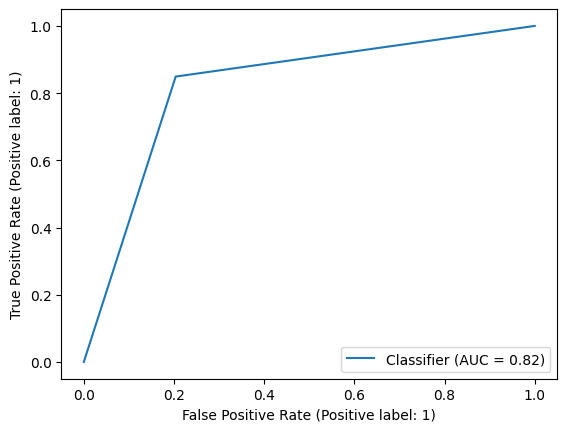

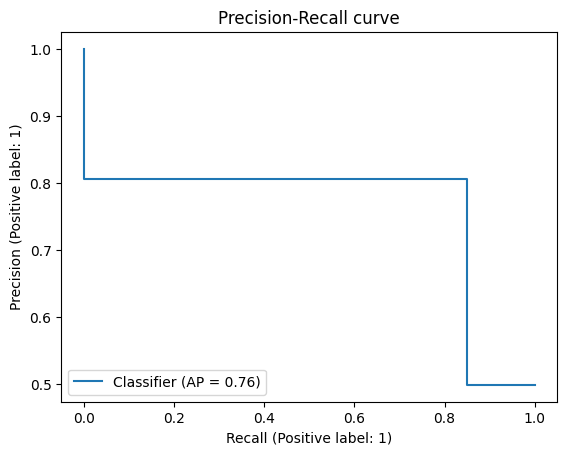

In [7]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
np.random.seed(42)

params = np.random.rand(X_train.shape[1]+1)

sgd_regression = LogReg(w0=params)

pred, roc = fit_train_predict_display(X_train, y_train, X_test, y_test, sgd_regression)

In [8]:
average_precision_score(y_test, pred)

0.7594519150372117

Данная модель, построенная на стохастическом градиентном спуске, хорошо предсказала тестовые данные. Я запускал алгоритм при разных параметрах по умолчанию и при max_iter = 1000, результаты получались очень посредственные. ROC_AUC был равен 0.65. Увеличив число итераций, модель стала предсказывать в разы лучше

Roc_auc =  0.5563186858852551


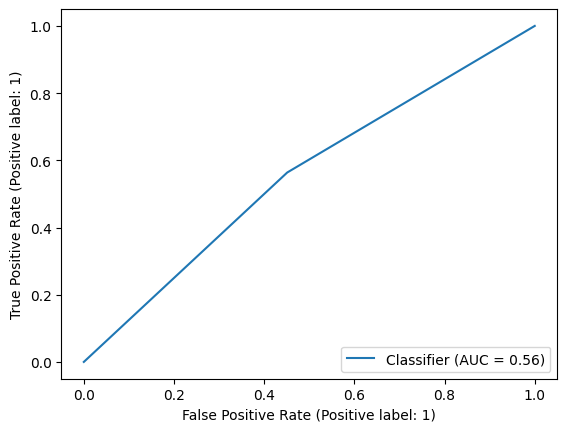

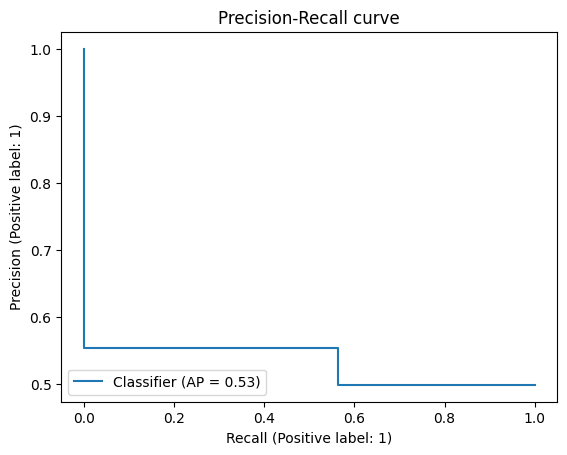

In [9]:
params = np.random.rand(X_train.shape[1]+1)

full_regression = LogReg(w0=params, gd_type='full')

pred, roc = fit_train_predict_display(X_train, y_train, X_test, y_test, full_regression)

In [10]:
average_precision_score(y_test, pred)

0.5300269594953906

А полный градиентный спуск предсказывает хуже, если немного увеличить learning_rate. Возможно там узкое место с глобальным минимумом, и мы его проскочили

## Часть 2. Работа с категориальными переменными (3 балла)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом для задания мы немного модифицируем датасет.

In [11]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [12]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [6]:
# удаляем наны и ресетим индексы

def preprocessing_df(X, y):
    X_concat = X.copy()
    X_concat['target'] = y
    X_dropna = X_concat.dropna().reset_index()
    y_new = X_dropna['target']
    X_new = X_dropna.drop(columns=['id', 'target'])

    return X_new, y_new

Roc_auc =  0.5697449762043276


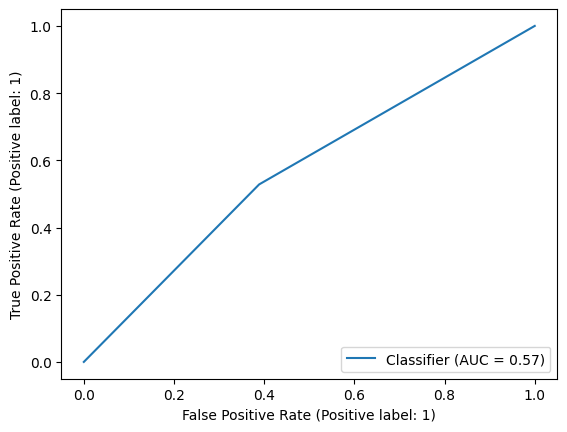

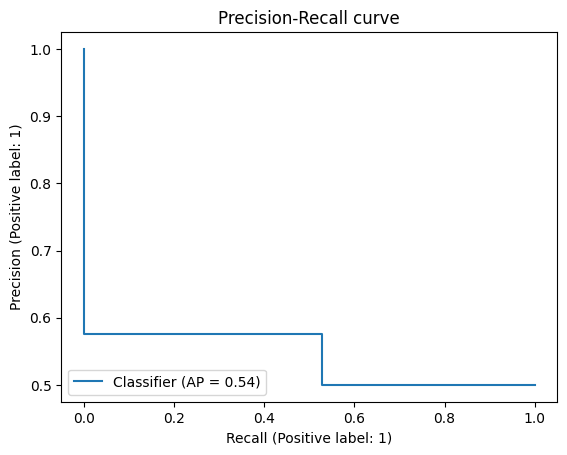

In [14]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
ins_params = np.random.rand(X_train.shape[1]+1)
#Это я тестировал разные начальные веса
zero_base_params = np.hstack((np.zeros_like(X_train, shape=57), 1))

X_train_new, y_train_new = preprocessing_df(X_train, y_train)
insurance_model = LogReg(w0 = zero_base_params)

ins_pred, roc = fit_train_predict_display(X_train_new, y_train_new, X_test, y_test, insurance_model)

**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [7]:
def cat_features(X):
    cat_columns = np.flatnonzero(np.core.defchararray.find(X.columns.to_list(), "cat")!=-1)
    cat_array = X[X.columns[cat_columns]]

    return cat_array

In [8]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import OneHotEncoder
# работаем с категориальными признаками

def encoding_data(X, encoder, test=False):

    cat_array = cat_features(X)
    if not test:
        encoded_cat = encoder.fit_transform(cat_array).toarray()
    else:
        encoded_cat = encoder.transform(cat_array).toarray()
    encoded_cat_df = pd.DataFrame(encoded_cat, columns = encoder.get_feature_names_out())
    X_wt_cat = X.drop(cat_array, axis = 1)
    X_encoded = pd.concat([X_wt_cat, encoded_cat_df], axis=1)
    return X_encoded

In [17]:
encoder = OneHotEncoder(drop='first')

X_train_enc = encoding_data(X_train_new, encoder)

<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  

Roc_auc =  0.5216198371113256
CPU times: user 2min 26s, sys: 23.9 s, total: 2min 50s
Wall time: 1min 36s


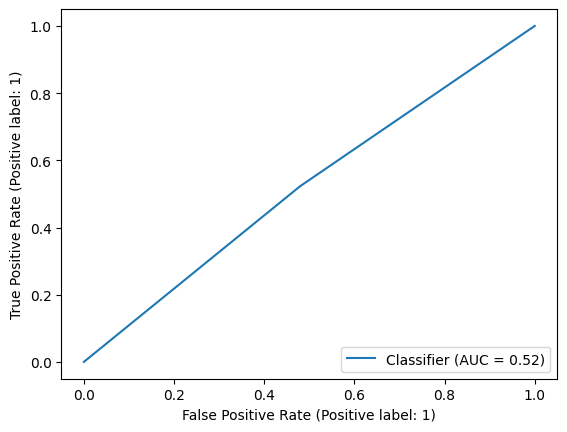

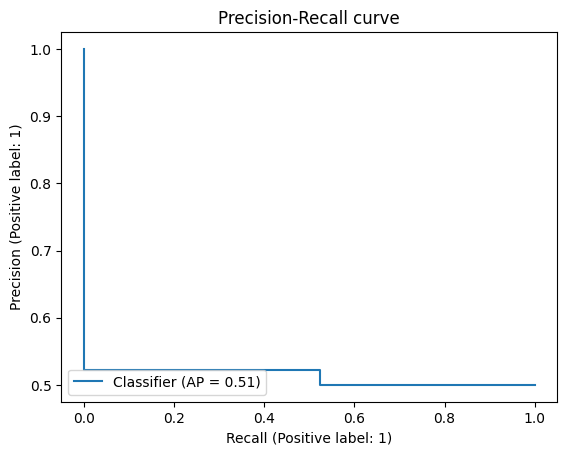

In [18]:
%%time
ins_cat_params = np.random.rand(X_train_enc.shape[1]+1)

insurance_cat_model = LogReg(w0 = ins_cat_params)

X_test_new, y_test_new = preprocessing_df(X_test, y_test)

X_test_enc = encoding_data(X_test_new, encoder, test=True)

ins_cat_pred, roc_cat = fit_train_predict_display(X_train_enc, y_train_new,
                                                  X_test_enc, y_test_new, insurance_cat_model)

Как можно было заменить, one-hot-кодирование сильно увилечивает количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (1.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?


In [19]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train_counters = X_train_new.copy()
X_train_counters['target'] = y_train_new

In [20]:
X_train_counters

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
0,0,1,5,0,0,1,0,0,0,0,...,3,4,6,0,0,0,0,0,0,0
1,1,1,3,1,0,0,1,0,0,0,...,0,4,12,0,1,1,0,0,0,1
2,6,2,7,1,0,0,0,1,0,0,...,1,2,7,0,1,1,0,1,0,0
3,1,1,5,1,0,0,0,1,0,0,...,2,2,10,0,0,1,0,0,0,1
4,0,1,1,0,4,1,0,0,0,0,...,1,2,14,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,1,5,0,0,0,1,0,0,0,...,1,0,5,1,1,1,0,1,0,1
99996,0,2,1,1,0,1,0,0,0,0,...,0,2,7,0,1,0,0,1,0,1
99997,5,1,3,1,0,0,1,0,0,0,...,2,1,7,0,0,0,1,0,0,0
99998,0,1,3,0,0,1,0,0,0,0,...,2,4,7,1,1,1,1,0,0,0


In [21]:
X_train_cat = cat_features(X_train_counters)

In [22]:
# мапа для таргет энкодинга. Если шум включен, то сразу добавляем к каждой категории

def counter_encoder_map(X, y_name, cat_column, add_noise=False):
    encoding_map = {}
    for category in X[cat_column].unique():
        category_mean = X[X[cat_column] == category][y_name].mean()
        encoding_map[category] = category_mean.round(4)
        if add_noise:
            noise = np.random.normal(0, 0.05, 1)
            encoding_map[category]+= noise[0]
    return encoding_map

In [23]:
# Мапа с мапами, для всех колонок

def counter_fit_transform(X, cat_columns, y_name=None, fit=True,
                          encoding_map_dict=None, add_noise=False):
    X_w_counters = X.copy()
    enc_map_dict = {}
    if fit:
        counter = 0
        for column in cat_columns:
            encoding_map = counter_encoder_map(X, y_name, column, add_noise)
            enc_map_dict[column] = encoding_map
            X_w_counters[column] = X_w_counters[column].map(encoding_map)

    else:
        if map is not None:
            counter = 0
            for column in encoding_map_dict:
                X_w_counters[column] = X_w_counters[column].map(encoding_map_dict[column])

    return X_w_counters, enc_map_dict

In [24]:
X_train_counter, enc_dict = counter_fit_transform(X_train_counters, X_train_cat.columns, 'target')

In [25]:
X_test_cat = cat_features(X_test_new)
X_test_counter, none_dict = counter_fit_transform(X_test_new, X_test_cat.columns, fit=False, encoding_map_dict=enc_dict)

In [26]:
X_test_counter

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,1,0.5086,2,0.4865,0.4794,0,0,1,0,0,...,7,2,4,7,0,0,0,0,1,0
1,4,0.5058,9,0.5168,0.4794,0,1,0,0,0,...,7,0,3,5,0,1,1,1,0,0
2,0,0.5086,1,0.4865,0.4794,0,1,0,0,0,...,4,2,3,8,0,1,0,0,0,0
3,7,0.5058,7,0.4865,0.4794,0,0,0,1,0,...,7,1,2,6,1,0,1,0,1,0
4,0,0.4954,4,0.4865,0.4794,1,0,0,0,0,...,4,1,3,6,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0.4954,3,0.4865,0.4794,1,0,0,0,0,...,6,3,2,6,1,1,0,0,0,0
99996,4,0.5058,5,0.4865,0.4794,1,0,0,0,0,...,5,4,2,11,1,0,0,0,1,0
99997,5,0.4954,6,0.4865,0.4794,0,1,0,0,0,...,7,2,3,7,0,0,1,0,1,0
99998,5,0.4954,4,0.4865,0.4794,0,1,0,0,0,...,7,0,2,6,0,0,0,0,0,0


<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  

Roc_auc =  0.5305000364392005
CPU times: user 52.7 s, sys: 18.6 s, total: 1min 11s
Wall time: 40.2 s


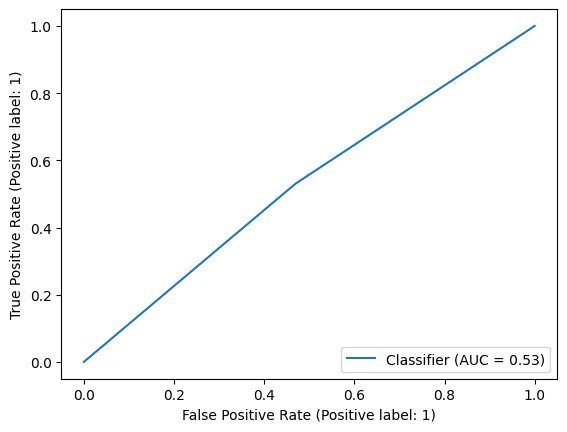

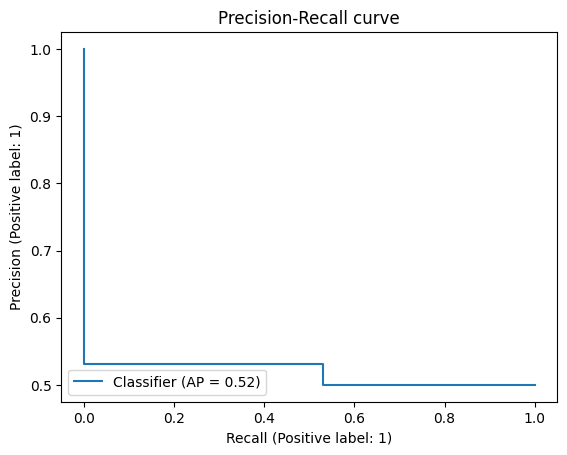

In [27]:
%%time
counter_model_params = np.random.rand(X_train_counter.shape[1])

counter_model = LogReg(w0 = counter_model_params)

counter_pred, roc_count = fit_train_predict_display(X_train_counter.drop('target', axis=1),
                                                    X_train_counter['target'],
                                                    X_test_counter,
                                                    y_test_new, counter_model)

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо так, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

__Задание 8 (1 балл)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [28]:
X_train_w_noise, noise_dict = counter_fit_transform(X_train_counters, X_train_cat.columns, 'target',
                                  add_noise=True)

In [29]:
X_train_w_noise

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
0,0,0.410005,5,0.462900,0.483212,1,0,0,0,0,...,3,4,6,0,0,0,0,0,0,0
1,1,0.410005,3,0.577561,0.483212,0,1,0,0,0,...,0,4,12,0,1,1,0,0,0,1
2,6,0.496706,7,0.577561,0.483212,0,0,1,0,0,...,1,2,7,0,1,1,0,1,0,0
3,1,0.410005,5,0.577561,0.483212,0,0,1,0,0,...,2,2,10,0,0,1,0,0,0,1
4,0,0.410005,1,0.462900,0.630560,1,0,0,0,0,...,1,2,14,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,0.410005,5,0.462900,0.483212,0,1,0,0,0,...,1,0,5,1,1,1,0,1,0,1
99996,0,0.496706,1,0.577561,0.483212,1,0,0,0,0,...,0,2,7,0,1,0,0,1,0,1
99997,5,0.410005,3,0.577561,0.483212,0,1,0,0,0,...,2,1,7,0,0,0,1,0,0,0
99998,0,0.410005,3,0.462900,0.483212,1,0,0,0,0,...,2,4,7,1,1,1,1,0,0,0


In [30]:
X_test_w_noise, empty_dict = counter_fit_transform(X_test_new, X_test_cat.columns,
                                       fit=False, encoding_map_dict=noise_dict, add_noise=True)

<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  

Roc_auc =  0.5297236704280208
CPU times: user 50.7 s, sys: 17.7 s, total: 1min 8s
Wall time: 38.6 s


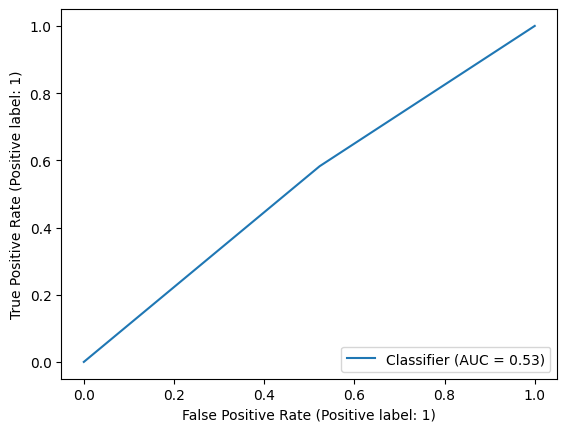

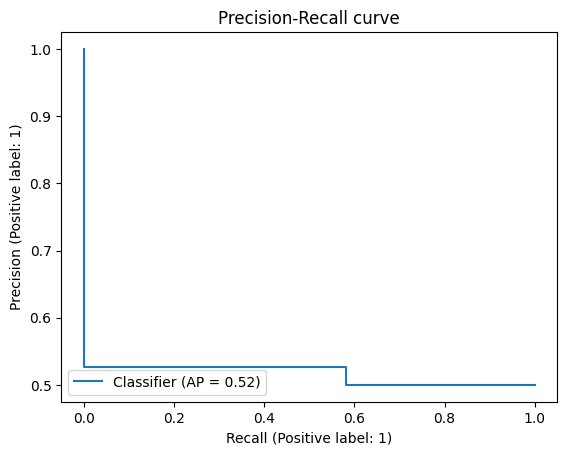

In [31]:
%%time
noise_model_params = np.random.rand(X_train_w_noise.shape[1])

noise_model = LogReg(w0 = noise_model_params)

noise_pred, roc_noise = fit_train_predict_display(X_train_w_noise.drop('target', axis=1),
                                                    X_train_w_noise['target'],
                                                    X_test_w_noise,
                                                    y_test_new, noise_model)

## Часть 3. Отбор признаков (3 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [9]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  

Roc_auc =  0.504086560945629


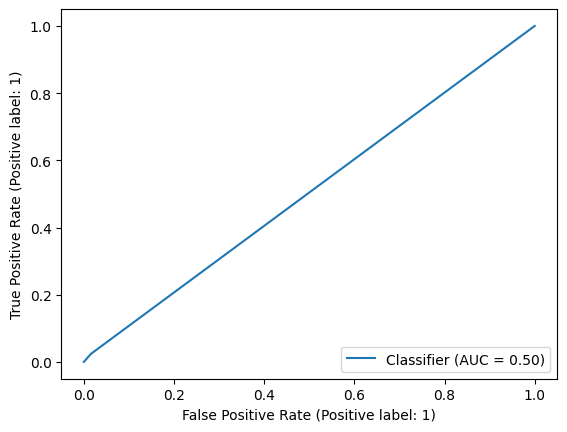

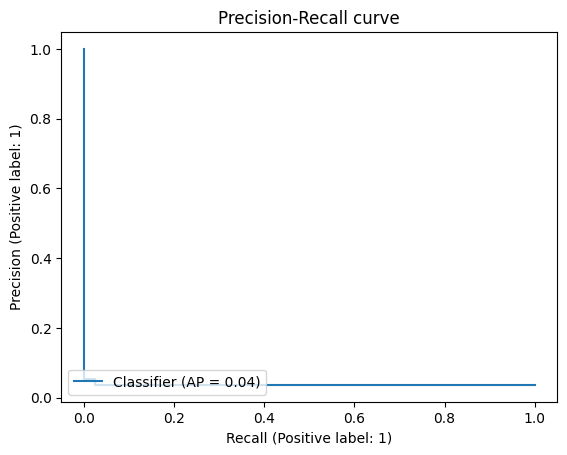

In [10]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
encoder = OneHotEncoder(drop='first')

X_train_new, y_train_new = preprocessing_df(X_train, y_train)

X_train_enc = encoding_data(X_train_new, encoder)

X_test_new, y_test_new = preprocessing_df(X_test, y_test)

X_test_enc = encoding_data(X_test_new, encoder, test=True)

ins_cat_params = np.random.rand(X_train_enc.shape[1]+1)

insurance_cat_model = LogReg(w0 = ins_cat_params)

ins_cat_pred, roc_cat = fit_train_predict_display(X_train_enc,
                                                    y_train_new,
                                                    X_test_enc,
                                                    y_test_new, insurance_cat_model)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (1 балл).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

In [11]:
X_train_enc

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,1,8,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,11,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,5,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476164,2,6,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
476165,1,7,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
476166,3,4,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
476167,3,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

weights = insurance_cat_model.w0

ind = np.argpartition(weights, -200)[-200:]
indexes = np.delete(ind, np.where(ind == 213))
X_top_200_train = X_train_enc[X_train_enc.columns[indexes]]

<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  

Roc_auc =  0.5030594924253888


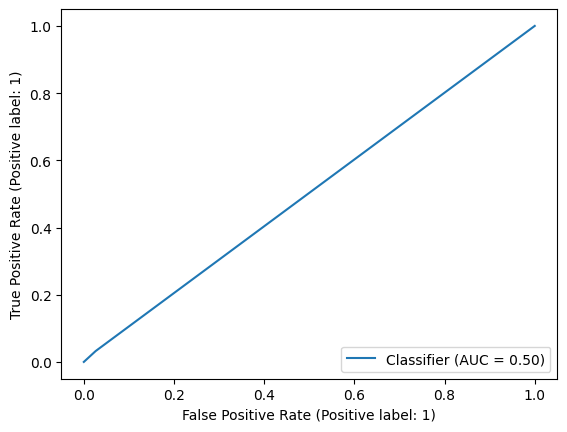

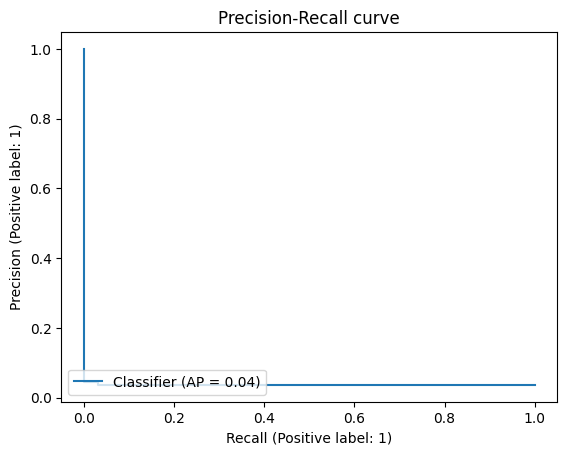

In [13]:
top_200_params = np.random.rand(200)

top_200_model = LogReg(w0 = top_200_params, max_iter=2000)

X_test_new, y_test_new = preprocessing_df(X_test, y_test)

X_test_enc = encoding_data(X_test_new, encoder, test=True)

X_top_200_test = X_test_enc[X_test_enc.columns[indexes]]

top_200_pred, roc_200 = fit_train_predict_display(X_top_200_train,
                                                    y_train_new,
                                                    X_top_200_test,
                                                    y_test_new, top_200_model)

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555327b4cfe0>:113: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sig) + (1 - y) * np.log(1 - sig)) / l
<ipython-input-3-555

Roc_auc =  0.5228700247381876


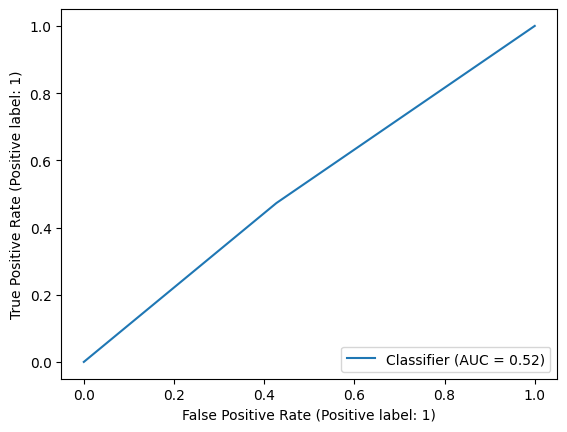

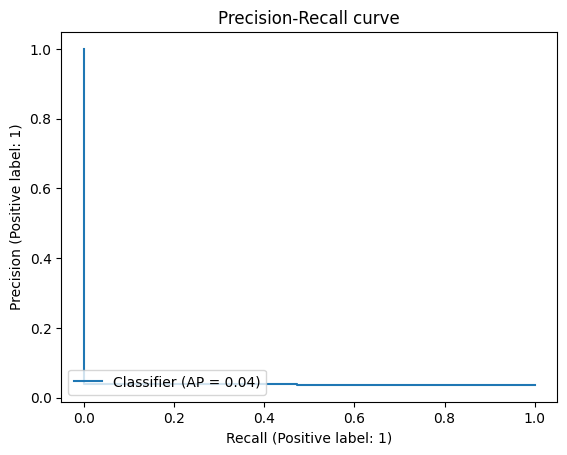

In [14]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

scaled_params = np.random.rand(X_train_scaled.shape[1]+1)
scaled_model = LogReg(w0 = scaled_params, max_iter=2000)

scaled_pred, roc_pred = fit_train_predict_display(X_train_scaled,
                                                    y_train_new,
                                                    X_test_scaled,
                                                    y_test_new, scaled_model)

In [15]:
weights = scaled_model.w0

ind = np.argpartition(weights, -200)[-200:]
indexes = np.delete(ind, np.where(ind == 213))

X_train_enc[X_train_enc.columns] = X_train_scaled
X_test_enc[X_test_enc.columns] = X_test_scaled

X_scaled_200_train = X_train_enc[X_train_enc.columns[indexes]]
X_scaled_200_test = X_test_enc[X_test_enc.columns[indexes]]

In [39]:
X_scaled_200_train

,ps_car_11_cat_79,ps_car_11_cat_60,ps_car_11_cat_80,ps_car_11_cat_66,ps_car_11_cat_57,ps_car_11_cat_69,ps_car_11_cat_39,ps_calc_12,ps_car_06_cat_4,ps_car_11_cat_45,...,ps_car_07_cat_1,ps_car_06_cat_16,ps_car_06_cat_5,ps_car_05_cat_1,ps_car_04_cat_7,ps_car_02_cat_1,ps_calc_11,ps_calc_04,ps_calc_02,ps_reg_01
0,-0.059129,-0.116647,-0.098646,-0.072357,-0.080357,-0.054768,8.775496,-0.366932,-0.234262,-0.053756,...,0.275770,-0.088168,-0.048447,-0.638824,-0.015744,0.452769,-1.474800,-0.332481,1.220523,-0.038452
1,-0.059129,-0.116647,-0.098646,-0.072357,-0.080357,-0.054768,-0.113954,-1.197520,4.268731,-0.053756,...,0.275770,-0.088168,-0.048447,-0.638824,-0.015744,0.452769,0.238818,0.562658,1.220523,0.657203
2,-0.059129,-0.116647,-0.098646,-0.072357,-0.080357,-0.054768,-0.113954,-0.366932,-0.234262,-0.053756,...,0.275770,-0.088168,-0.048447,-0.638824,-0.015744,0.452769,1.524032,-1.227620,0.523860,-0.038452
3,-0.059129,-0.116647,-0.098646,-0.072357,-0.080357,-0.054768,-0.113954,-0.366932,-0.234262,-0.053756,...,0.275770,-0.088168,-0.048447,1.565375,-0.015744,-2.208631,1.095627,-0.332481,0.175528,-1.429762
4,-0.059129,-0.116647,-0.098646,-0.072357,-0.080357,-0.054768,-0.113954,0.463656,-0.234262,-0.053756,...,0.275770,-0.088168,-0.048447,-0.638824,-0.015744,0.452769,1.524032,-1.227620,0.175528,-0.734107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476164,-0.059129,-0.116647,-0.098646,-0.072357,-0.080357,-0.054768,-0.113954,-0.366932,-0.234262,-0.053756,...,-3.626207,-0.088168,-0.048447,-0.638824,-0.015744,0.452769,-0.189586,0.562658,0.175528,1.005031
476165,-0.059129,-0.116647,-0.098646,-0.072357,-0.080357,-0.054768,-0.113954,-0.366932,-0.234262,-0.053756,...,0.275770,-0.088168,-0.048447,1.565375,-0.015744,0.452769,-0.189586,-2.122759,0.523860,-0.038452
476166,-0.059129,-0.116647,-0.098646,-0.072357,-0.080357,-0.054768,-0.113954,-0.366932,-0.234262,-0.053756,...,0.275770,-0.088168,-0.048447,-0.638824,-0.015744,0.452769,-0.189586,-0.332481,0.872191,-0.386280
476167,-0.059129,-0.116647,-0.098646,-0.072357,-0.080357,-0.054768,-0.113954,-1.197520,-0.234262,-0.053756,...,0.275770,-0.088168,-0.048447,-0.638824,-0.015744,0.452769,1.524032,1.457797,0.175528,0.657203


__Задание 10 (0.5 балла).__
Можно задать отбор признаков более функционально. Вспомним, что L1-регуляризация также умеет отбирать признаки. Понятно, что теперь нам будет сложнее оставить именно 200 лучших признаков, но возможно они нам и не нужны. Подберите коэффициент регуляризации и проверьте, как изменилось качество. Получилось ли добиться лучшего качества при менее чем 200 признаках?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
%%time
from sklearn import linear_model

clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=1000,
                                      warm_start=True,
                                      intercept_scaling=1000.).fit(X_scaled_200_train, y_train_new)

pred = clf.predict(X_scaled_200_test)

roc_curve = RocCurveDisplay.from_predictions(y_true=y_test_new, y_pred=pred)

Качество модели не изменилось!
Я тут успел обучить ее несколько раз, но в последний раз не успел, на бОльшем количестве итераций. Не хотел терять пол балла, поэтому сдаю так
Но в целом качество осталось таким же
Оперативы жрет немеренно!


### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

__Задание 11 (1 балл)__. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

### Методы-обёртки

__Задание 12 (бонус, 1 балл)__.


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

**Ответ:** Наверно лучшим способом закодировать признаки был target encoder, но только без утечки данных. One hot encoder создает большое количество признаков, что сильно увеличивает время обучения модели. Даже в этом задании, это очень сильно сказалось на качестве выполнения дз, потому что 1000 итераций было мало, а 10к итераций - слишком долго, учитывая что надо обучать множество моделей.

Также важную роль играет выборка, на данной выборке было скучно экспериментировать, потому что показатели не менялись при малом количестве итераций градиентного спуска. А при больших - слишком долго.